In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

from tensorflow.keras import layers

E0000 00:00:1753183691.131741      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230
Matplotlib is building the font cache; this may take a moment.


In [39]:
# Config 
INPUT_DIR = Path("/kaggle/working/output_wav2vec_custom_augmented")
OUTPUT_DIR = Path("./output_tsfmr_lr2_class_tpu")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 16
EPOCHS = 400
LEARNING_RATE = 1e-6
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
OUTPUT_DIR = Path("./")
BEST_MODEL_PATH = OUTPUT_DIR / "best_tsfmr_lr2_model.keras"

In [3]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

--- Initializing TPU Strategy ---
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753183729.178482      10 service.cc:148] XLA service 0x5c5026197d40 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753183729.178528      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753183729.178533      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753183729.178536      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753183729.178538      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753183729.178541      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753183729.178544      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753183729.178546      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753183729.178549      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
print("\nLoading all compressed features")

train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']


print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Loading all compressed features
All compressed data loaded successfully.
X_train shape: (33043, 150, 768)
y_train shape: (33043, 6)


In [7]:
# Remove the last column ('NoStutter') from the labels
y_train = y_train[:, :-1]
y_val = y_val[:, :-1]
y_test = y_test[:, :-1]

# Filter out samples that now have NO labels
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and modified successfully.")
print(f"New X_train shape: {X_train.shape}")

Data loaded and modified successfully.
New X_train shape: (28881, 150, 768)


In [8]:
print("\n Verifying final training set distribution after augmentation")

final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))


 Verifying final training set distribution after augmentation
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10203
WordRep         10040
dtype: int64


In [9]:
print("\nBuilding tf.data pipeline")

def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")


Building tf.data pipeline
Datasets created successfully.


In [ ]:
with strategy.scope():
    print("\nBuilding Transformer Model")
    # Transformer Encoder Block 
    def transformer_encoder(x, num_heads=4, ff_dim=128, dropout=0.1):
        # Attention and Normalization
        x_attn = layers.LayerNormalization(epsilon=1e-6)(x)
        x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM // num_heads)(x_attn, x_attn)
        x_attn = layers.Dropout(dropout)(x_attn)
        x = x + x_attn # Residual connection

        # Feed Forward Network
        x_ff = layers.LayerNormalization(epsilon=1e-6)(x)
        x_ff = layers.Dense(ff_dim, activation="relu")(x_ff)
        x_ff = layers.Dropout(dropout)(x_ff)
        x_ff = layers.Dense(EMBEDDING_DIM)(x_ff)
        x = x + x_ff # Residual connection
        
        return x

    def build_transformer_classifier(input_shape, num_classes):
        inputs = layers.Input(shape=input_shape)
        x = inputs
        
        # Applies Transformer encoder blocks
        x = transformer_encoder(x, num_heads=4, ff_dim=256)
        x = transformer_encoder(x, num_heads=4, ff_dim=256)
        
        # Pool the sequence to a single vector
        x = layers.GlobalAveragePooling1D()(x)
        
        # Classifier head
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='sigmoid')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        # stable training params
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc', multi_label=True)]
        )
        return model

    model = build_transformer_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)

print(f"LEARNING RATE: {LEARNING_RATE}")
print(f"BATCH SIZE: {BATCH_SIZE}")


Building Transformer Model


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 150, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ input_layer_4[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 768)  │  2,362,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 150, 768)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 150, 768)  │          0 │ input_layer_4[0]… │
│                     │                   │            │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 150, 256)  │    196,864 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 150, 256)  │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 150, 768)  │    197,376 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 150, 768)  │          0 │ add_8[0][0],      │
│                     │                   │            │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 768)  │  2,362,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 150, 768)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 150, 768)  │          0 │ add_9[0][0],      │
│                     │                   │            │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 150, 256)  │    196,864 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 150, 256)  │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 150, 768)  │    197,376 │ dropout_21[0][0]

 Total params: 5,618,437 (21.43 MB)

 Trainable params: 5,618,437 (21.43 MB)

 Non-trainable params: 0 (0.00 B)

LEARNING RATE: 1e-06
BATCH SIZE: 128


In [41]:
print("\nStarting Training on TPU")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


Starting Training on TPU
Epoch 1/400


I0000 00:00:1753200451.678964      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:5036743501553499090
I0000 00:00:1753200453.076408     771 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(6342325636881818351), session_name()
I0000 00:00:1753200464.711001     771 tpu_compile_op_common.cc:245] Compilation of 6342325636881818351 with session name  took 11.634479835s and succeeded
I0000 00:00:1753200464.761512     771 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(6342325636881818351), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_5036743501553499090", property.function_library_fingerprint = 4758278964592585703, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z 

225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1936 - auc: 0.4957 - loss: 0.7595 - precision: 0.3544 - recall: 0.2796

I0000 00:00:1753200474.337990     767 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(8688879759369705507), session_name()
I0000 00:00:1753200484.549921     767 tpu_compile_op_common.cc:245] Compilation of 8688879759369705507 with session name  took 10.211879564s and succeeded
I0000 00:00:1753200484.588240     767 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(8688879759369705507), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_5036743501553499090", property.function_library_fingerprint = 4758278964592585703, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "11,150,768,;11,5,;", property.guaranteed_constants_size = 0, embedding_pa

226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.1936 - auc: 0.4958 - loss: 0.7593 - precision: 0.3545 - recall: 0.2794

I0000 00:00:1753200501.380738      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:8982449451044983571
I0000 00:00:1753200501.814556     825 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(8604944064599555283), session_name()
I0000 00:00:1753200504.089839     825 tpu_compile_op_common.cc:245] Compilation of 8604944064599555283 with session name  took 2.275169546s and succeeded
I0000 00:00:1753200504.096966     825 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(8604944064599555283), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_8982449451044983571", property.function_library_fingerprint = 11952233390729152748, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z 


Epoch 1: val_auc improved from -inf to 0.54783, saving model to best_tsfmr_lr2_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 71s 182ms/step - accuracy: 0.1936 - auc: 0.4958 - loss: 0.7591 - precision: 0.3545 - recall: 0.2792 - val_accuracy: 0.1088 - val_auc: 0.5478 - val_loss: 0.6763 - val_precision: 0.3929 - val_recall: 0.0089
Epoch 2/400
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2204 - auc: 0.5214 - loss: 0.6755 - precision: 0.3990 - recall: 0.1661
Epoch 2: val_auc improved from 0.54783 to 0.58793, saving model to best_tsfmr_lr2_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - accuracy: 0.2204 - auc: 0.5216 - loss: 0.6754 - precision: 0.3991 - recall: 0.1659 - val_accuracy: 0.1546 - val_auc: 0.5879 - val_loss: 0.6685 - val_precision: 0.5588 - val_recall: 0.0306
Epoch 3/400
225/226 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2307 - auc: 0.5618 - loss: 0.6555 - precision: 0.4628 - recall: 0.1369
Epoch 3: val_auc improved from 0.58793 to 0.61187, saving model to b


--- Evaluating Model on the Test Set ---


I0000 00:00:1753207721.552036      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:17786695622213974722
E0000 00:00:1753207721.611743      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_4_1/dense_16_1/BiasAdd/ReadVariableOp.
I0000 00:00:1753207721.754768     752 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(9932359133895655660), session_name()
I0000 00:00:1753207723.506146     752 tpu_compile_op_common.cc:245] Compilation of 9932359133895655660 with session name  took 1.751318053s and succeeded
I0000 00:00:1753207723.509207     752 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(9932359133895655660), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_17786695622213974722", property.function_library_fingerprint = 13309691673289439747, property.mlir_module_finge

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

I0000 00:00:1753207729.313640      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:15148116016014886295
I0000 00:00:1753207729.616685     812 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(9857273600343199660), session_name()
I0000 00:00:1753207731.034041     812 tpu_compile_op_common.cc:245] Compilation of 9857273600343199660 with session name  took 1.417309166s and succeeded
I0000 00:00:1753207731.037076     812 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(9857273600343199660), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_15148116016014886295", property.function_library_fingerprint = 16913243545915730888, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topo

55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 205ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.69      0.40      0.50      2613
       Block       0.62      0.44      0.52      3501
    SoundRep       0.61      0.46      0.52      1891
     WordRep       0.51      0.48      0.49      1742
Interjection       0.87      0.60      0.71      3344

   micro avg       0.67      0.48      0.56     13091
   macro avg       0.66      0.47      0.55     13091
weighted avg       0.68      0.48      0.56     13091
 samples avg       0.60      0.50      0.51     13091


--- Generating plots for model training history... ---


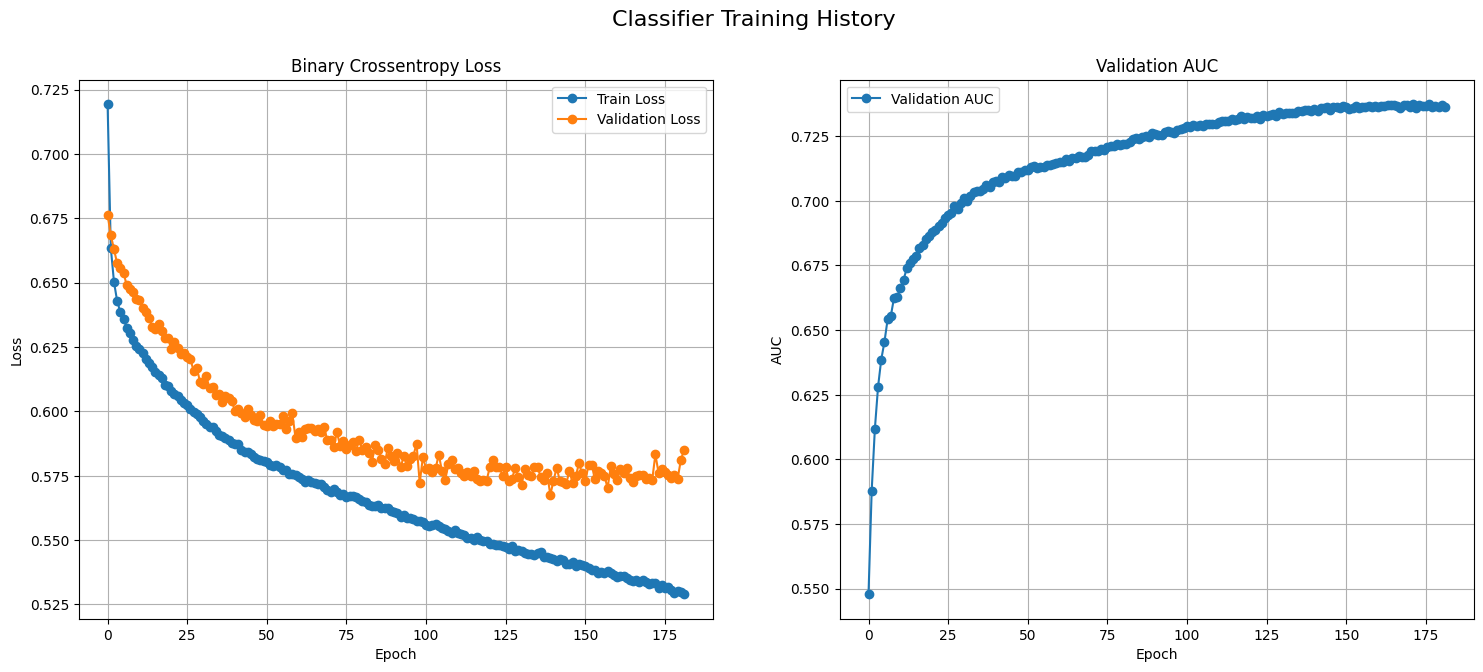


--- Generating Per-Class Precision-Recall Curves... ---


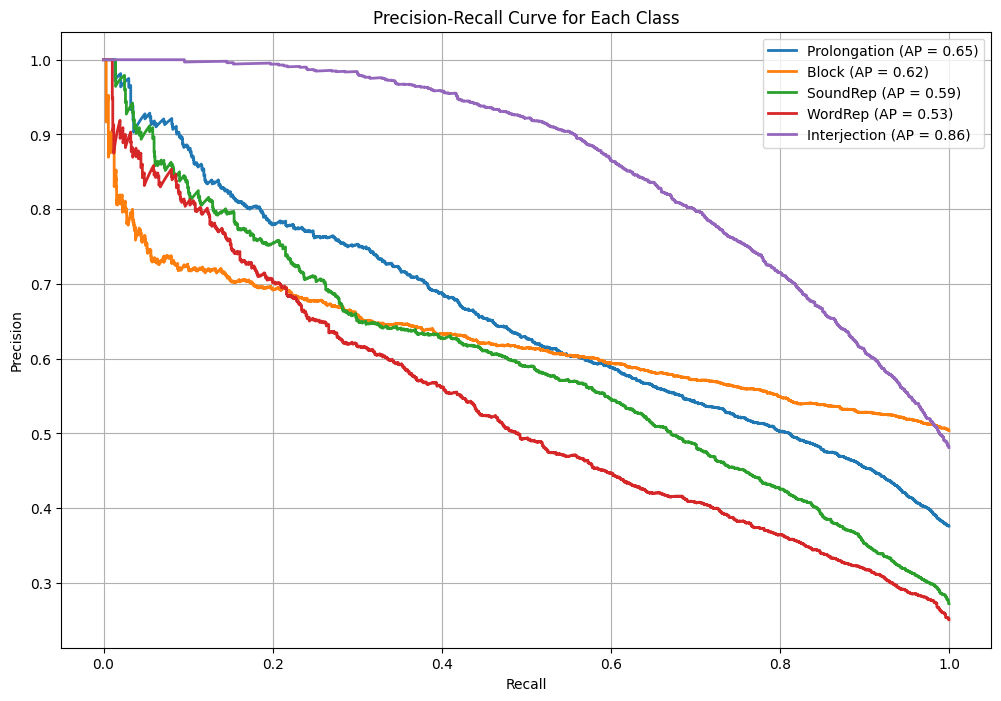

In [ ]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()

print("\n--- Generating Per-Class Precision-Recall Curves... ---")
plt.figure(figsize=(12, 8))

for i in range(len(LABEL_COLS)):
    precision, recall, _ = precision_recall_curve(y_test_eval[:, i], y_pred_probs[:, i])
    # Calculate Average Precision (AP), which is similar to AUC for PR curves
    ap = average_precision_score(y_test_eval[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'{LABEL_COLS[i]} (AP = {ap:0.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision-Recall Curve for Each Class")
plt.grid(True)
plt.savefig(OUTPUT_DIR / "precision_recall_curves.png")
plt.show()

